In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf

/home/anels/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [3]:
def genSignal(dt_stock, df):    
    buy = [np.nan] * len(df)
    sell = [np.nan] * len(df)
    txt = [""] * len(df)

    now = datetime.now()
    for i in range(len(dt_stock)):
        tt = datetime.strptime(dt_stock.iloc[i]['Date'], "%m/%d/%Y")
        if (now - tt).days > 20:
            continue
        idx = df.index[df['Time'] == nearest(df['Time'], tt)][0]
        price = df.iloc[idx]["close"]
        amount = int(dt_stock.iloc[i]["Shares"].replace(',', ''))
        total = amount * price

        if dt_stock.iloc[i]['Direction'] == "Buy":
            buy[idx] = price #float(dt_stock.iloc[0]['Shares'])
        else:
            sell[idx] = price #float(dt_stock.iloc[0]['Shares'])
        #txt[idx] = f"${(total / 1000.0):.2f}k ({(amount / 1000.0):.2f}k@{price:.2f})"
        txt[idx] = f"${(total / 1000000.0):.2f}m"
    
    return (buy, sell, txt)

In [17]:
def refresh(ticker, period="30d", interval="1d"):
    df = yf.Ticker(ticker).history(period=period, interval=interval)

    df["Time"] = df.index
    df["Date"] = df["Time"].dt.strftime("%y/%m/%d")
    df = df[1:]
    df = df.dropna(subset=["High", "Low", "Open", "Close", "Volume"])

    if df.iloc[-1]["Volume"] == 0:
        df.drop(df.tail(1).index, inplace=True)

    df.index = range(0, len(df))

    df.rename(
        columns={
            "High": "high",
            "Low": "low",
            "Open": "open",
            "Close": "close",
            "Volume": "volume",
        },
        inplace=True,
    )

    return df

In [18]:
data = pd.read_csv('log/ark_2020_11.csv')

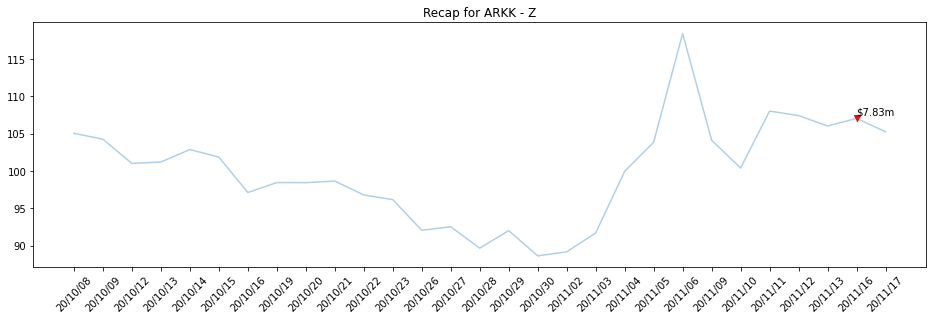

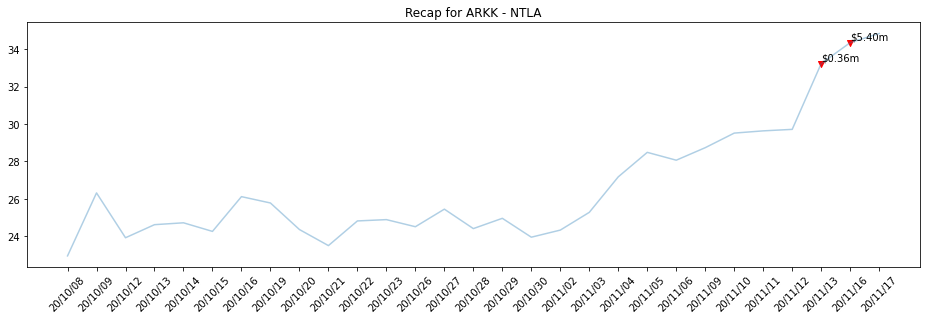

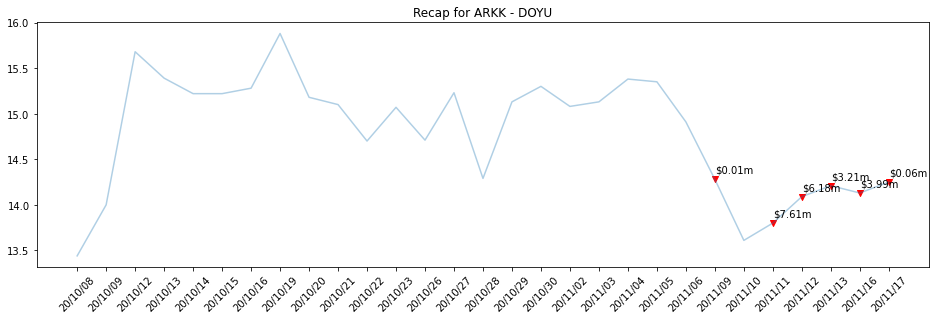

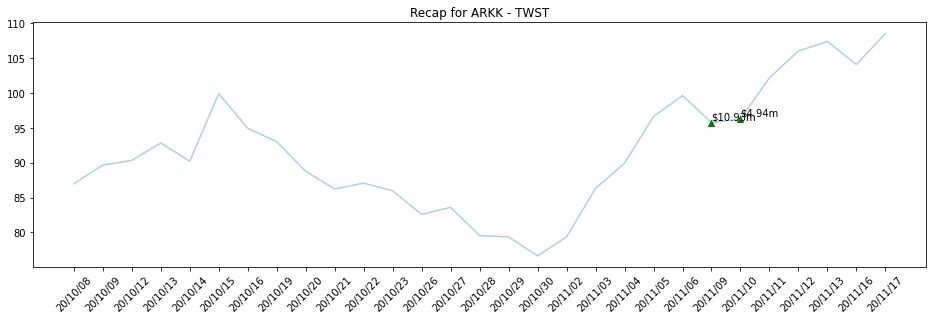

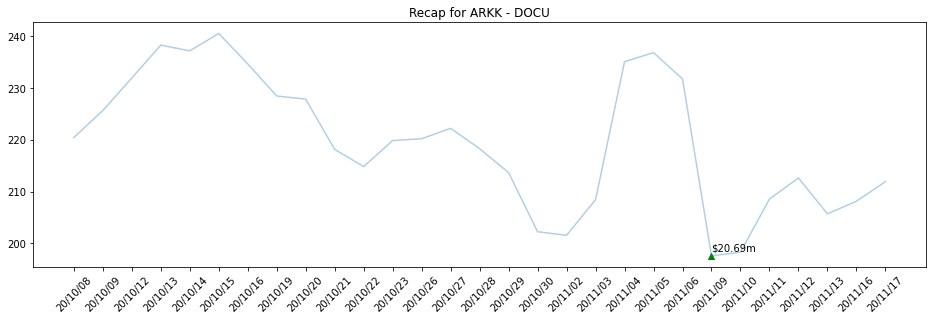

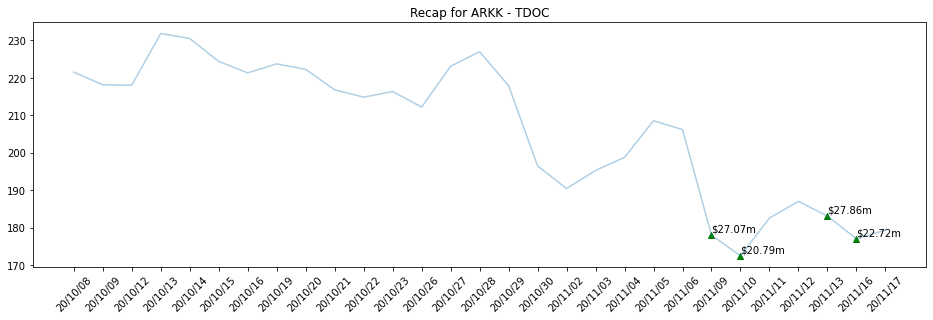

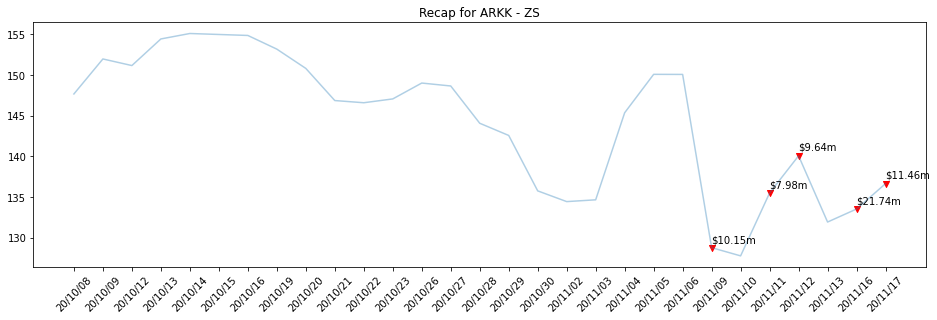

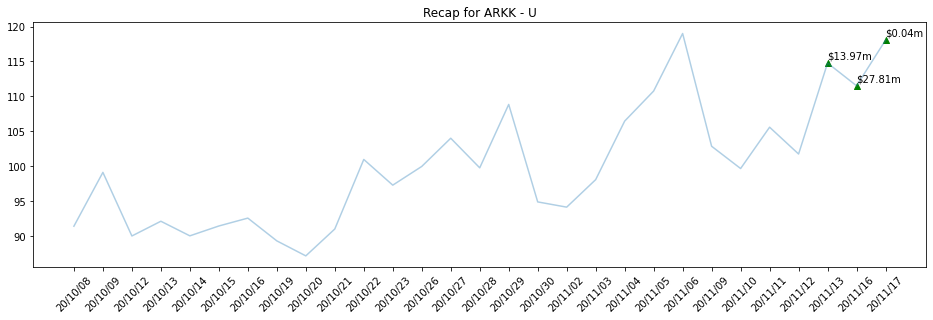

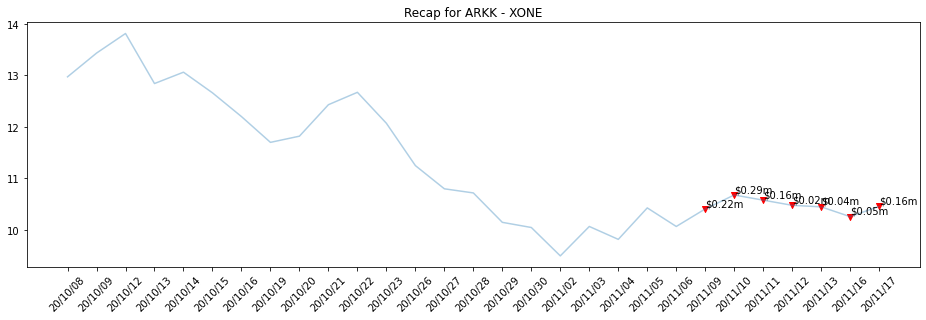

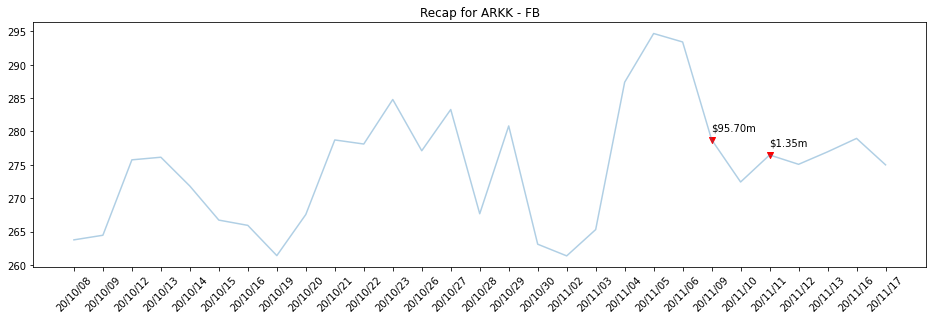

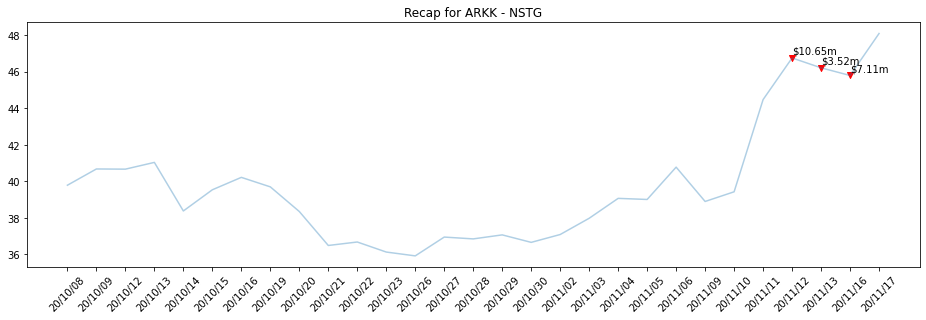

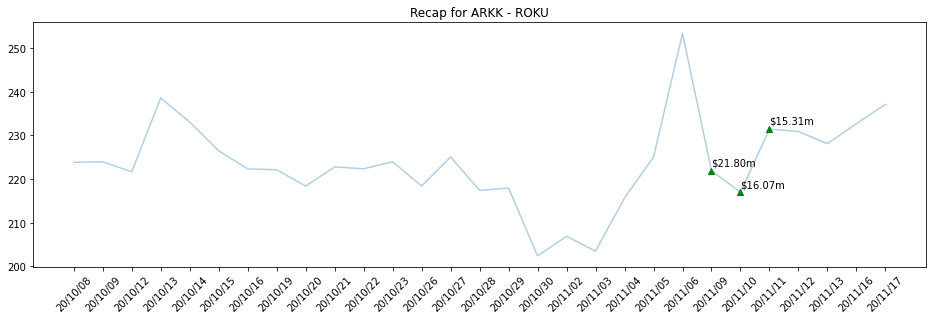

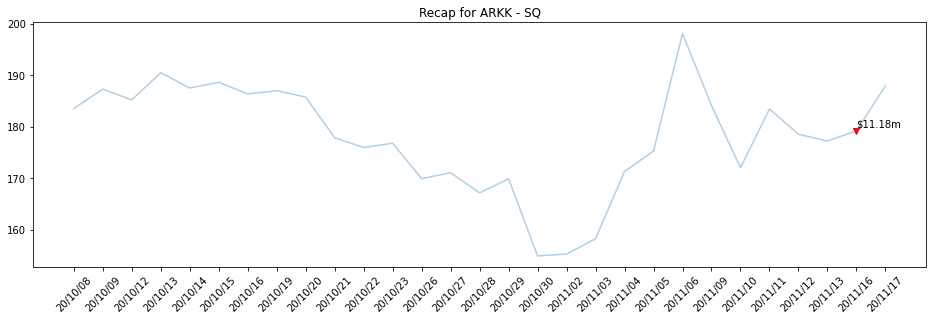

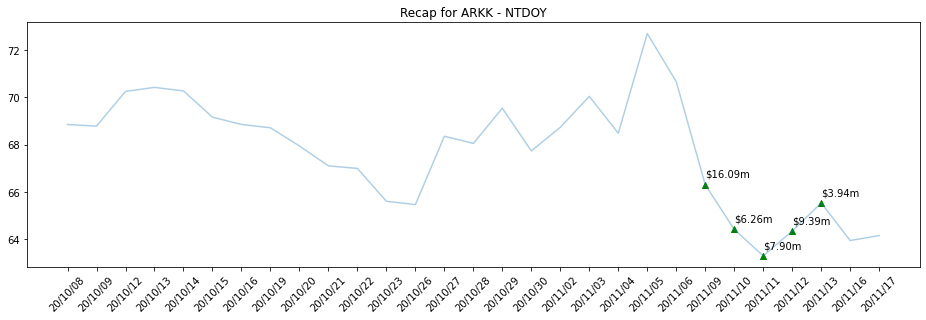

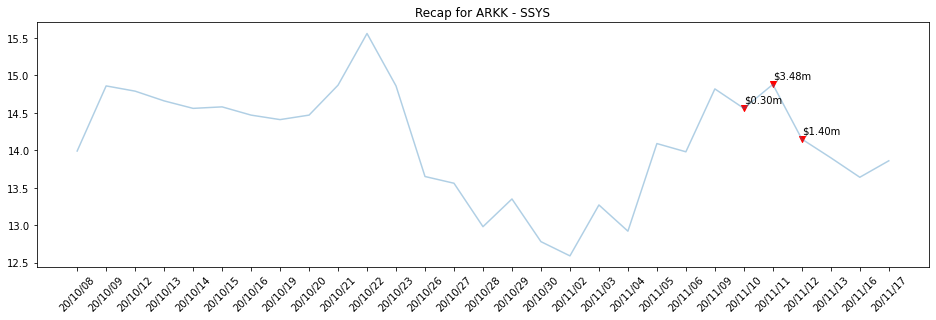

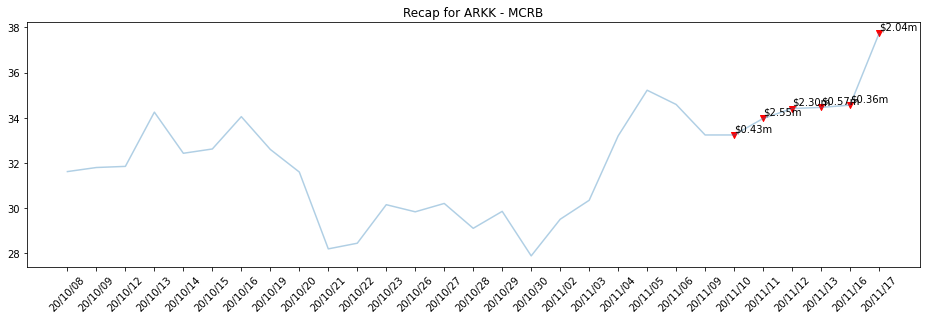

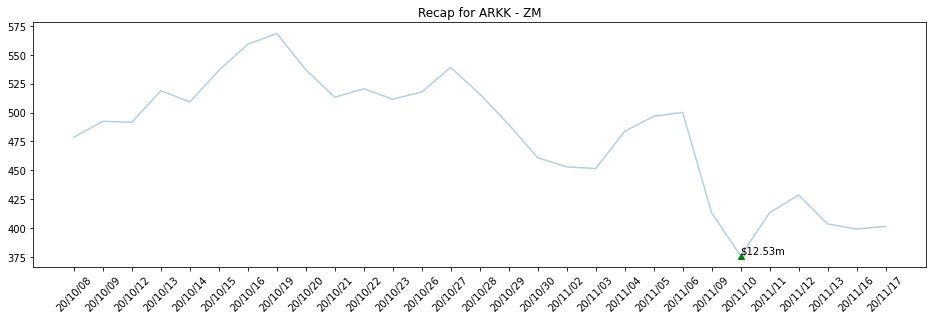

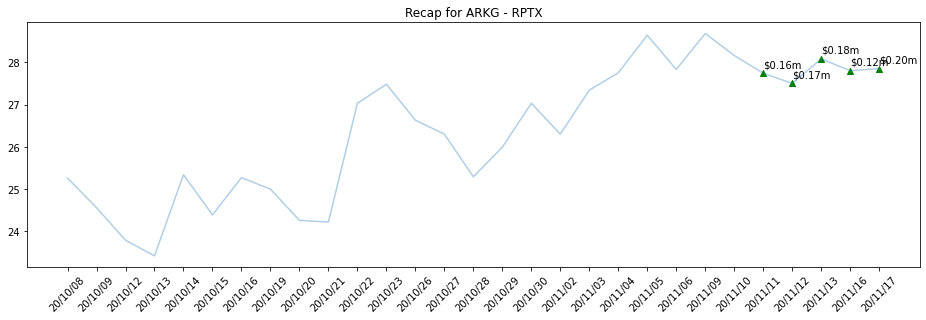

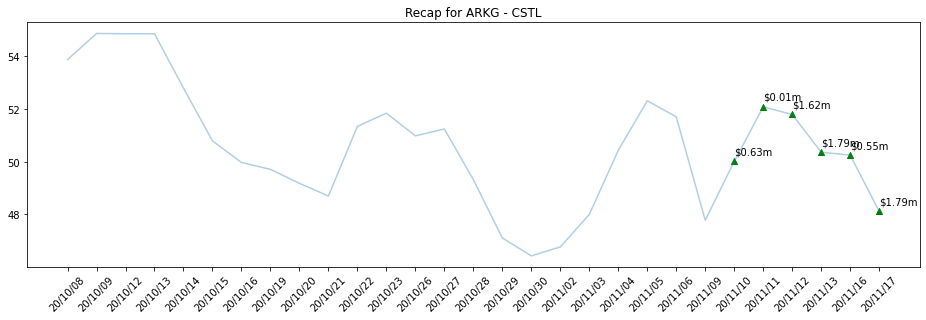

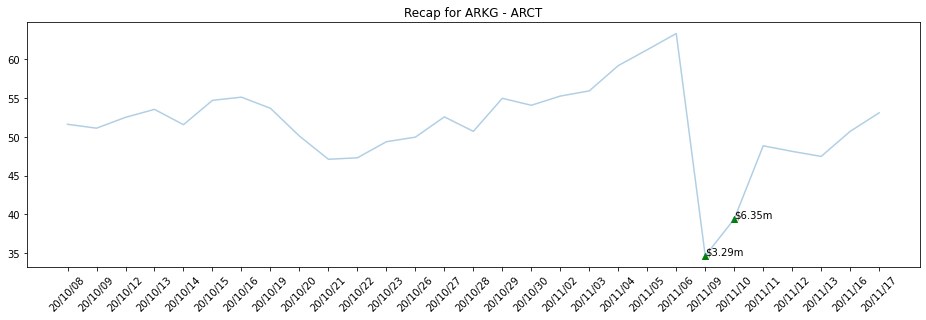

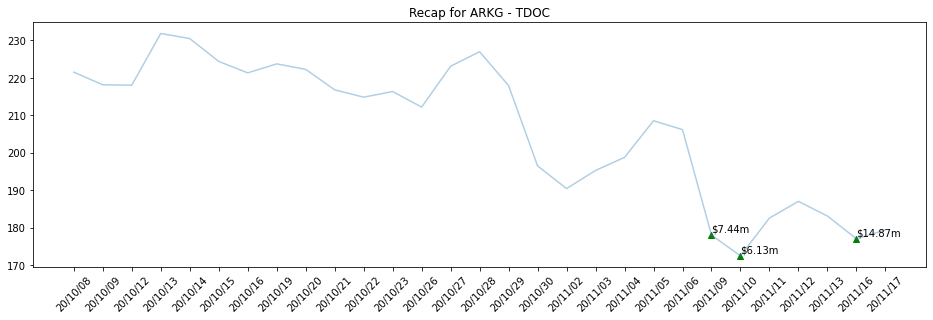

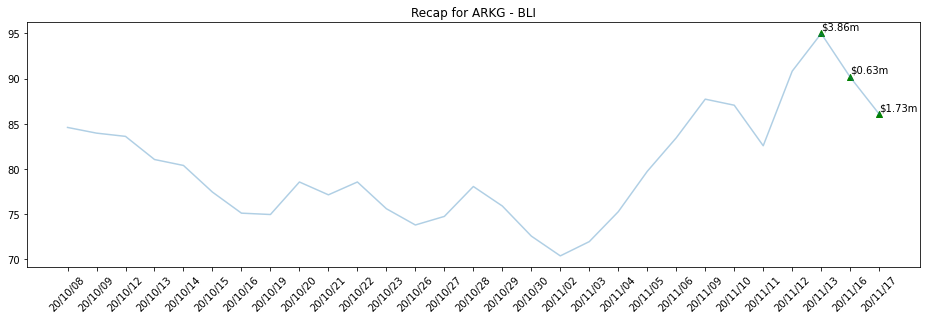

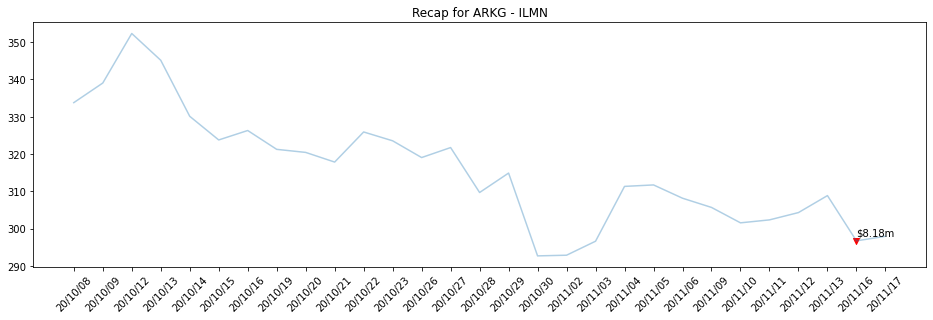

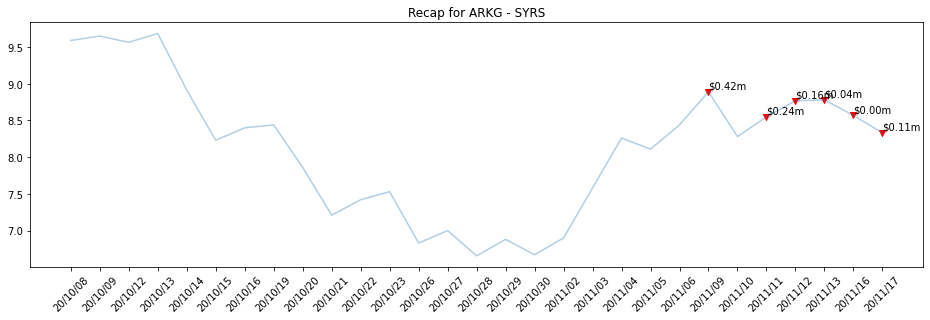

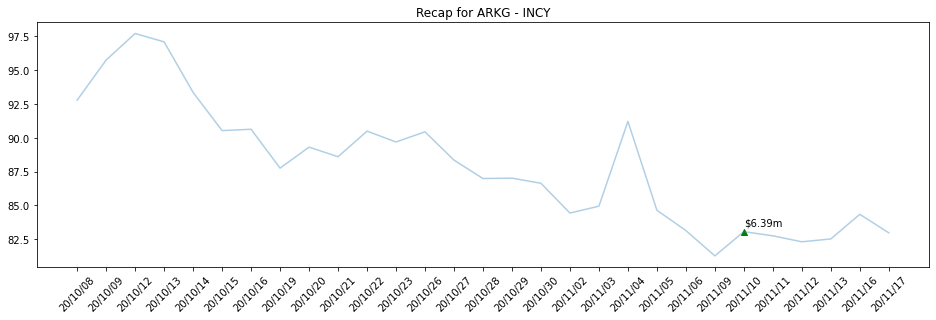

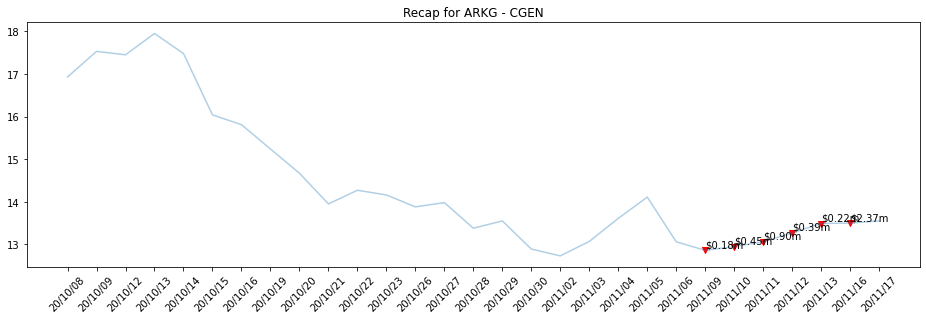

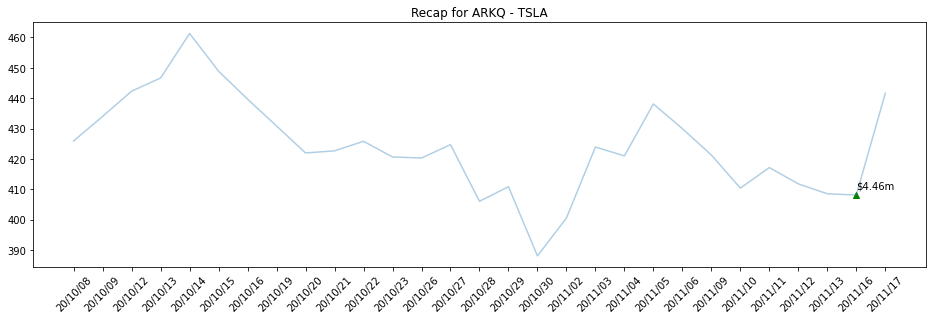

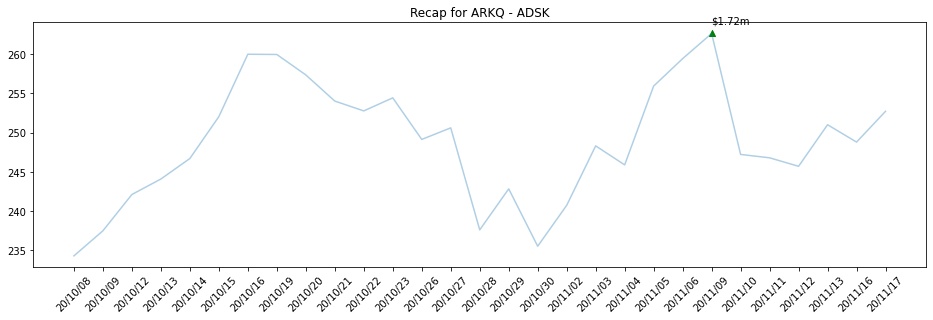

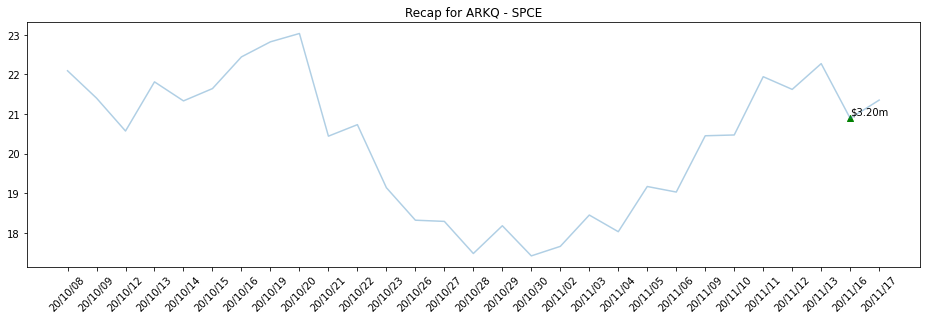

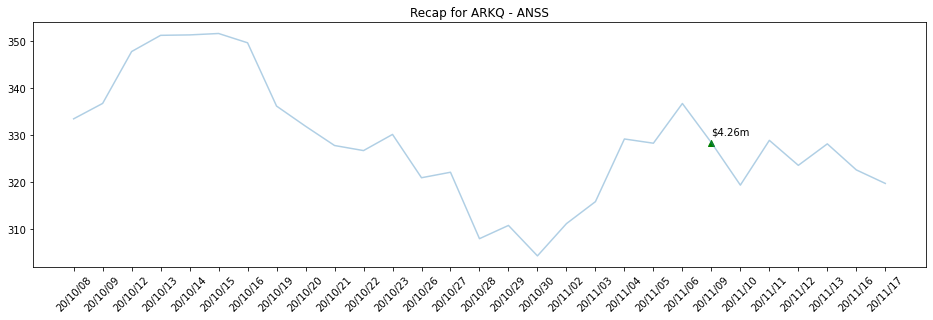

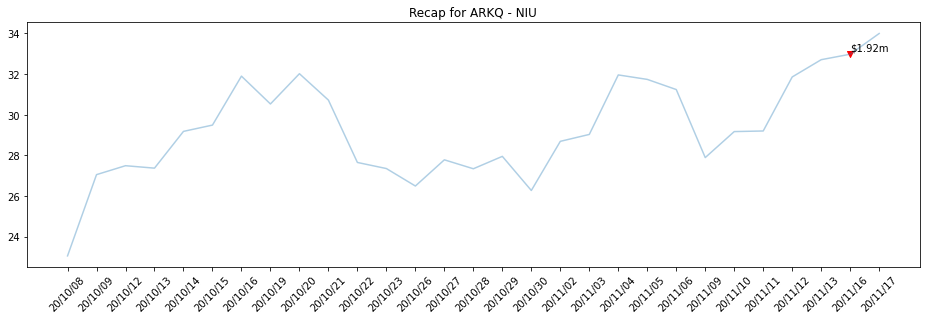

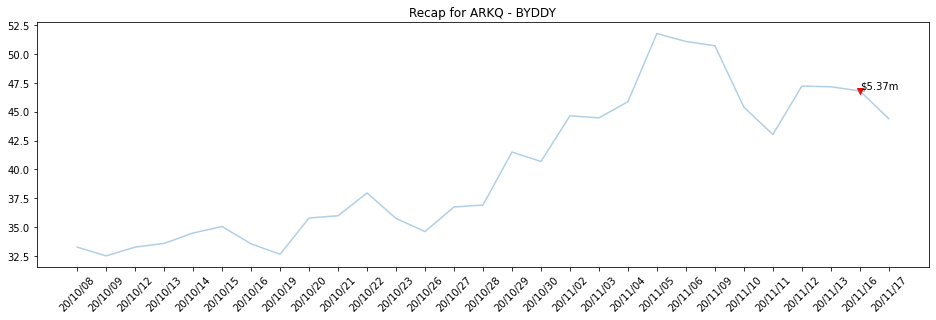

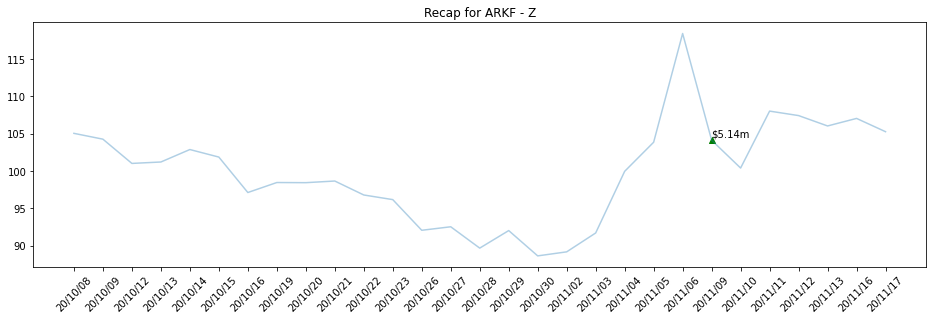

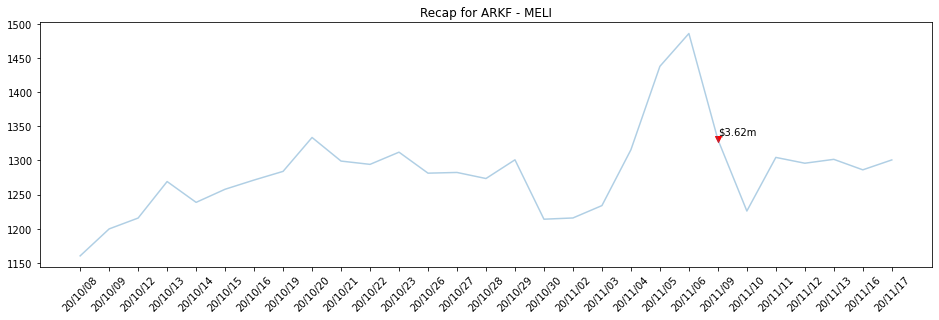

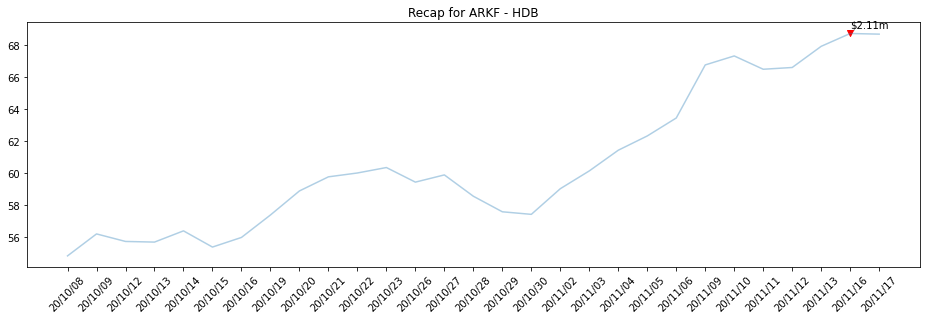

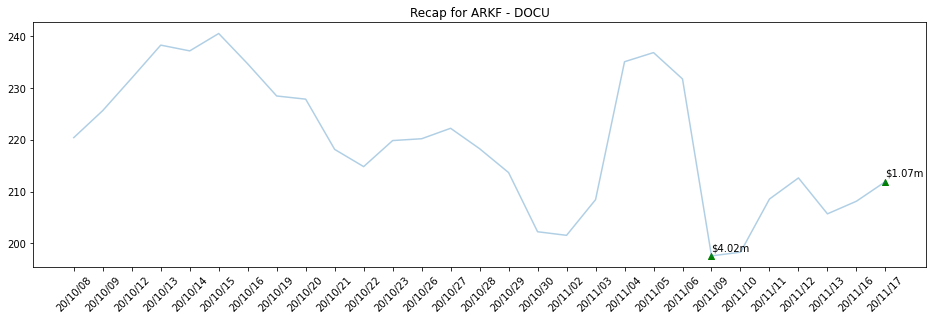

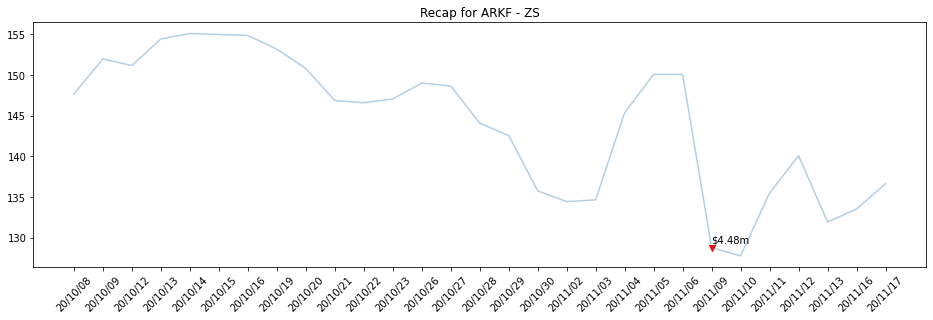

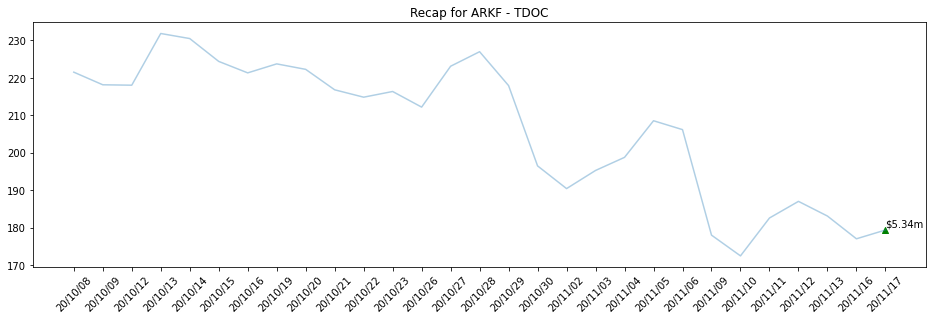

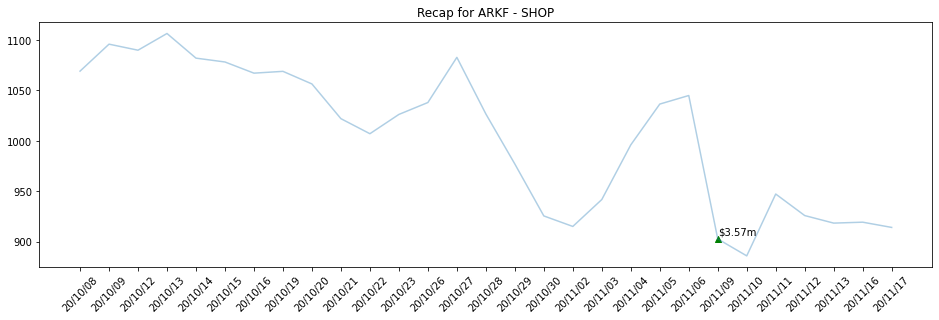

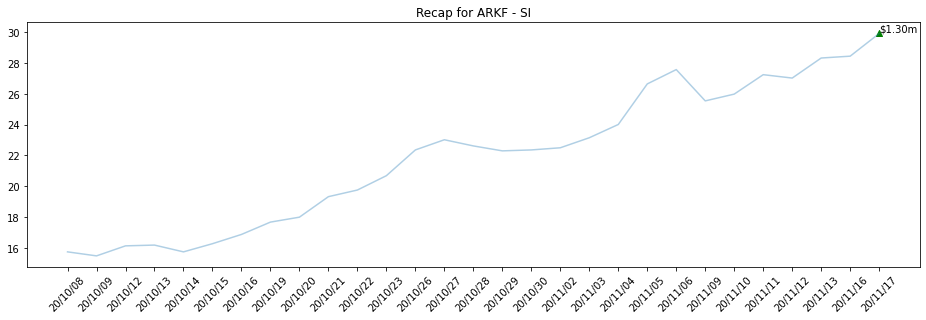

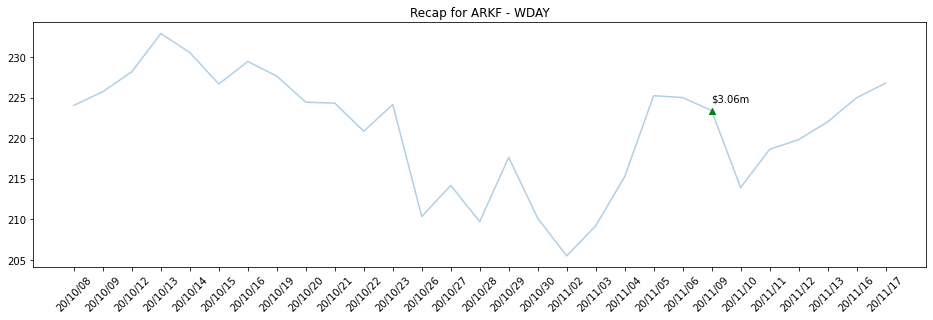

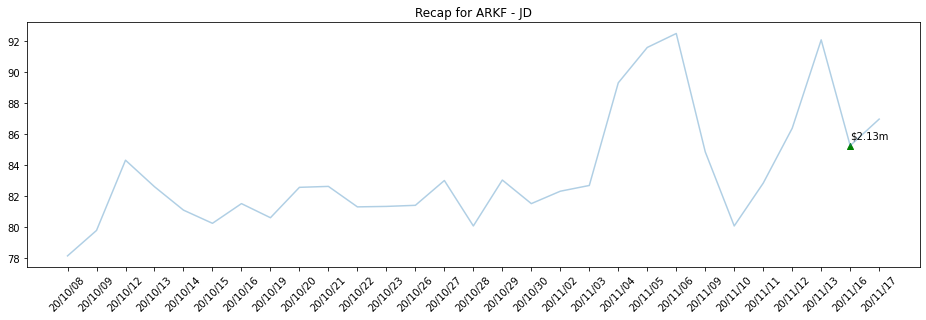

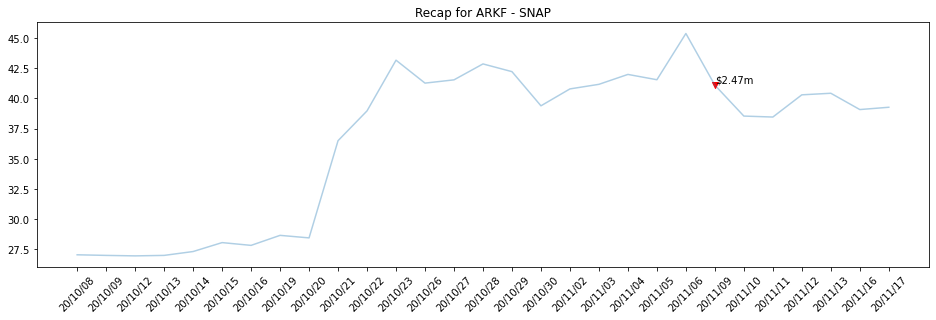

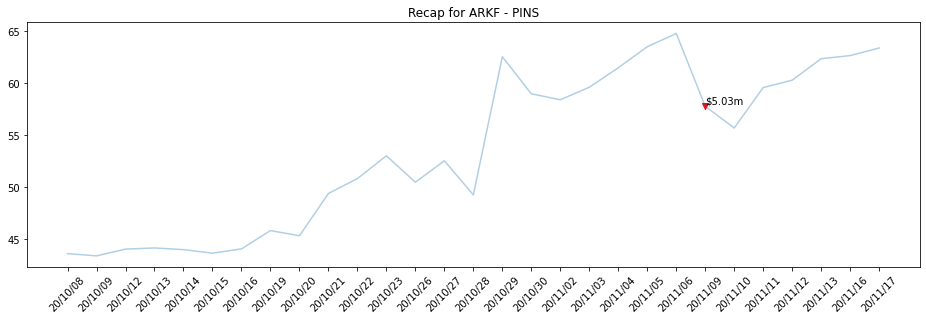

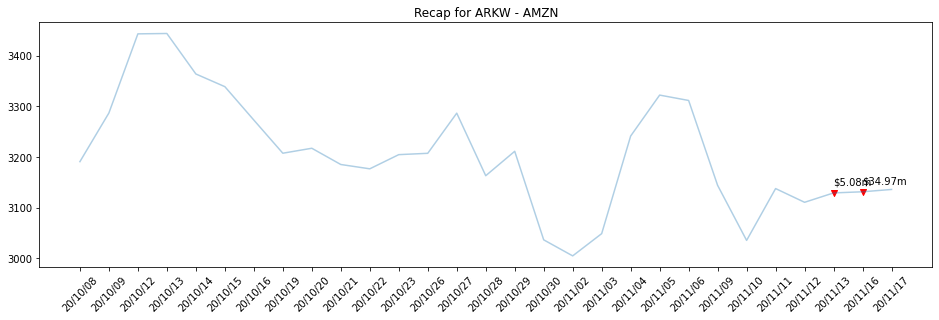

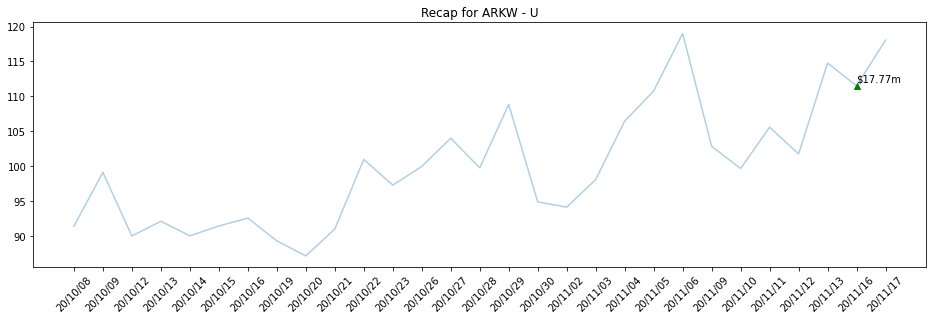

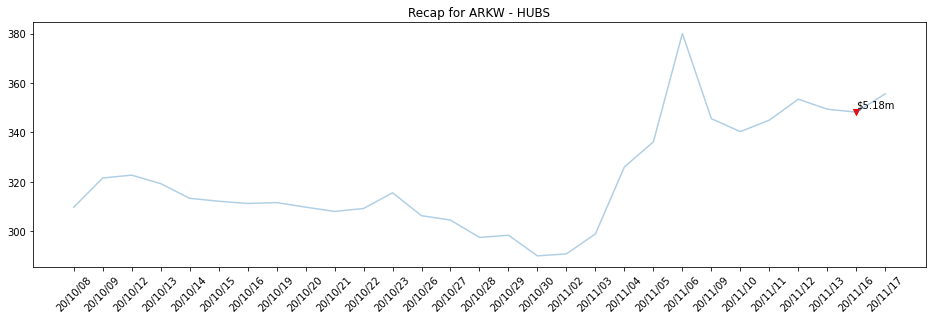

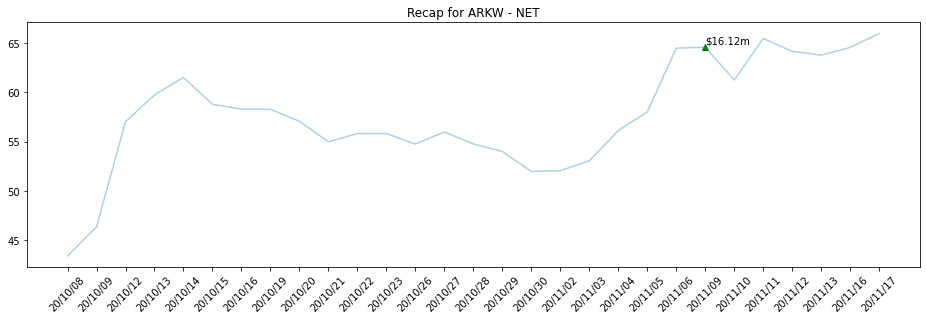

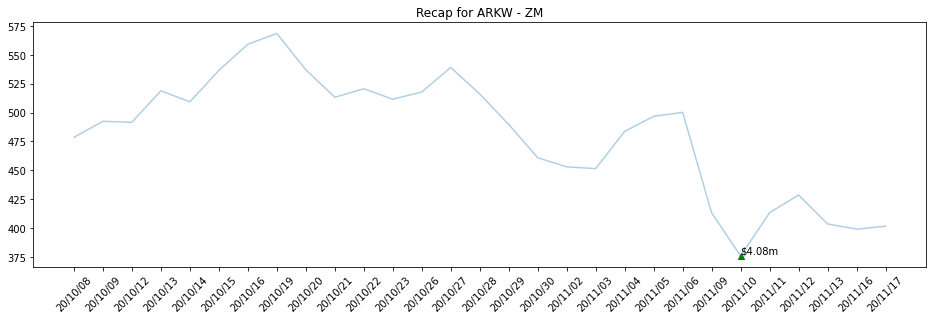

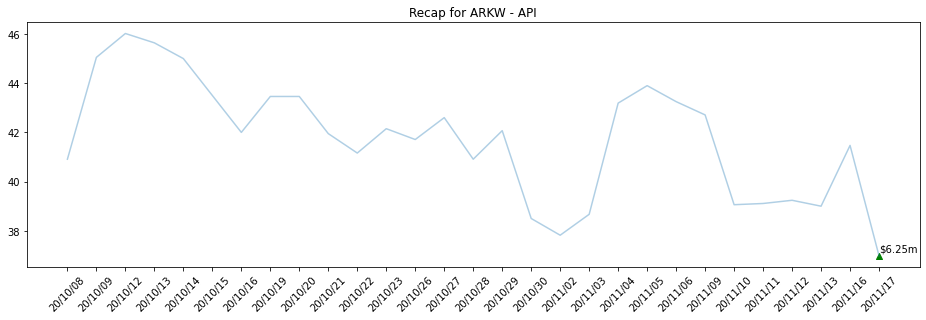

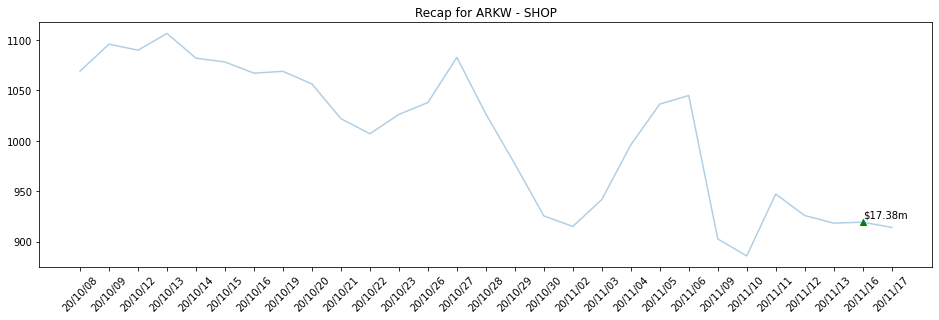

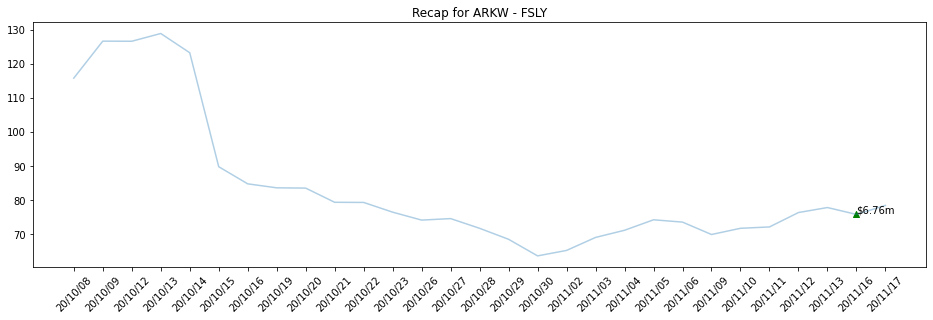

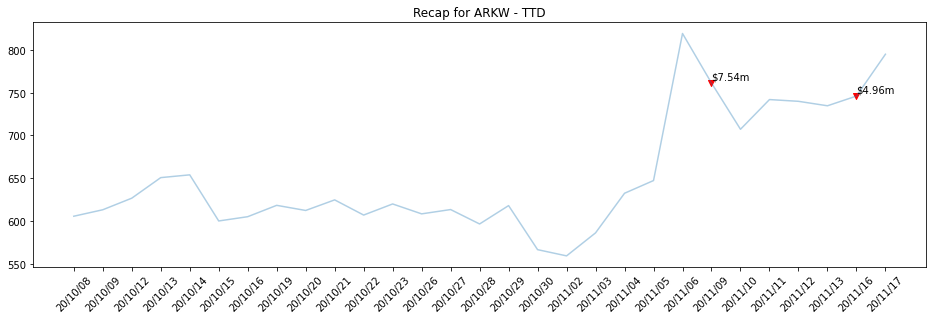

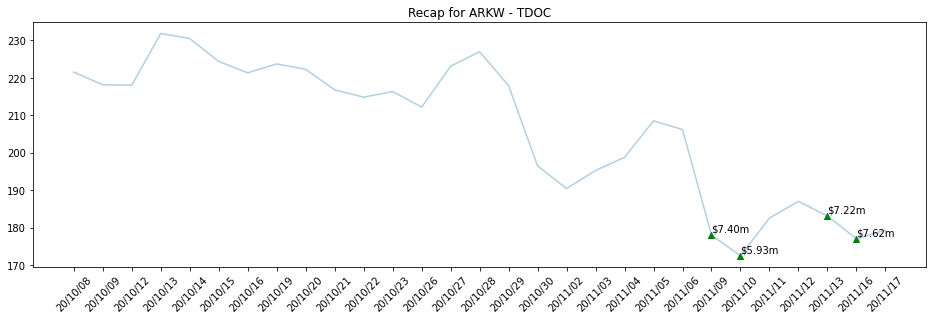

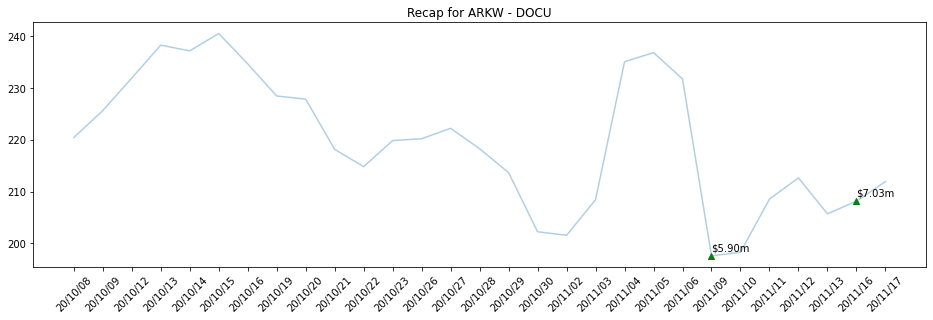

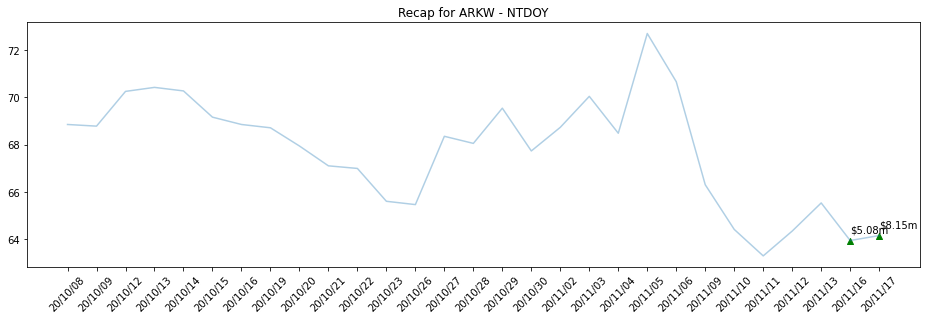

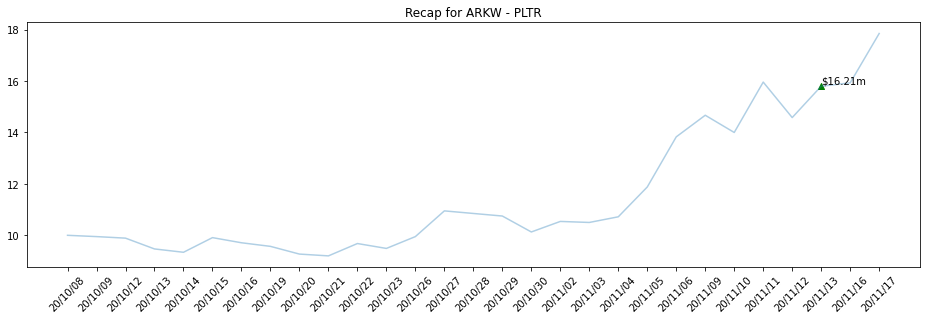

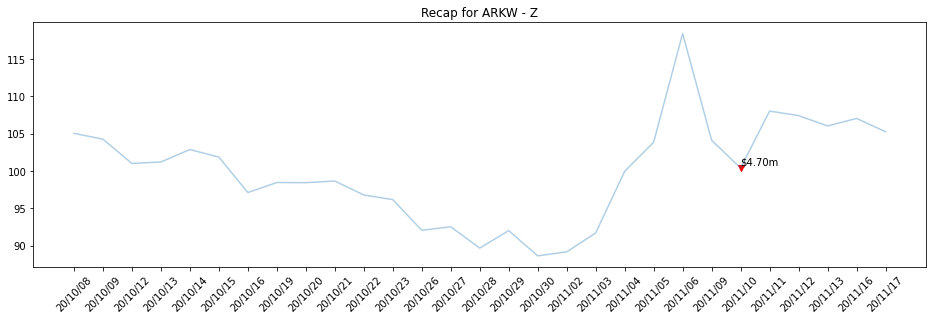

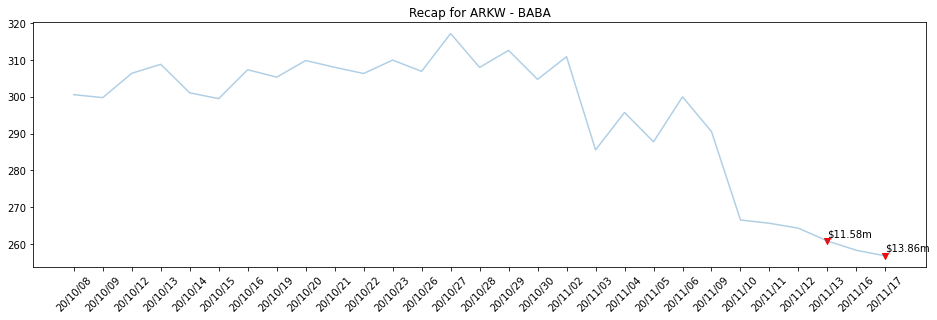

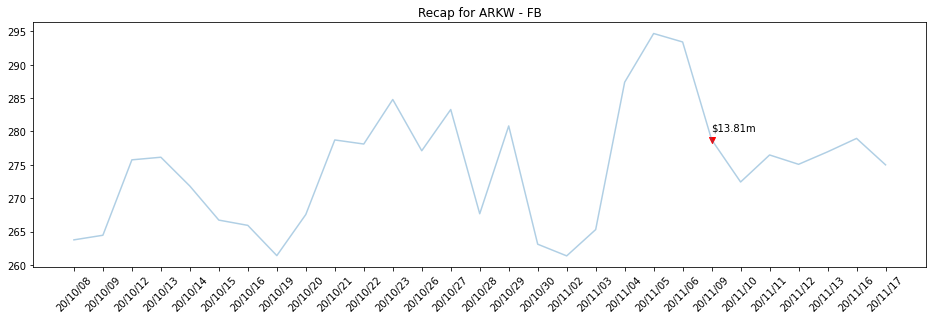

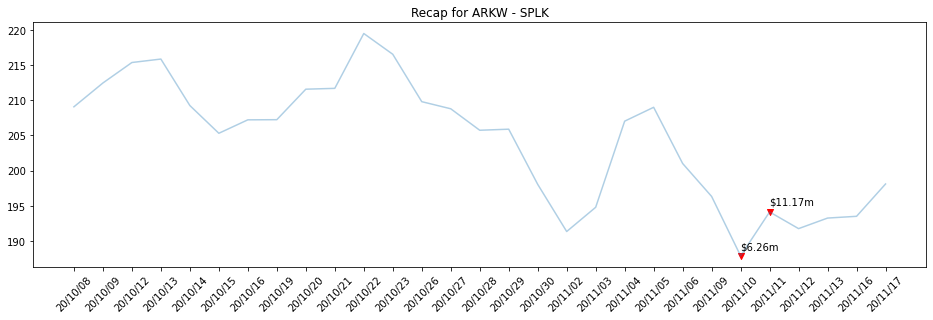

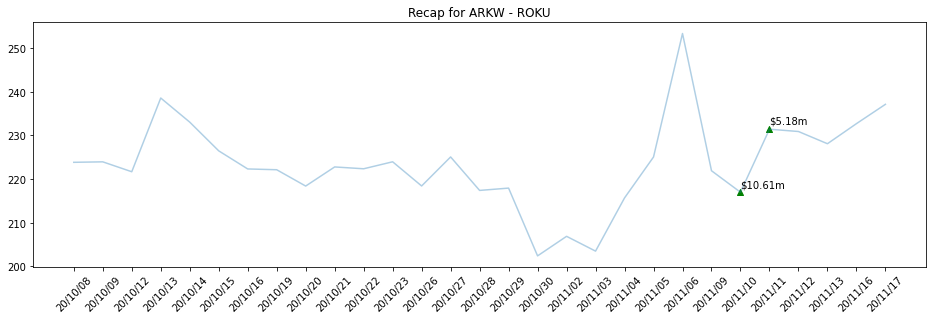

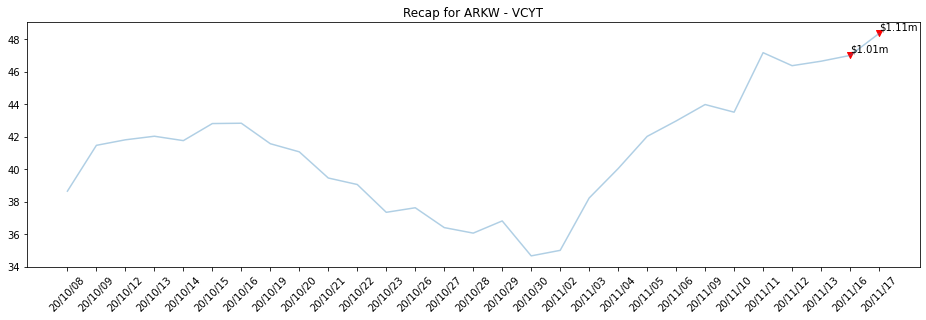

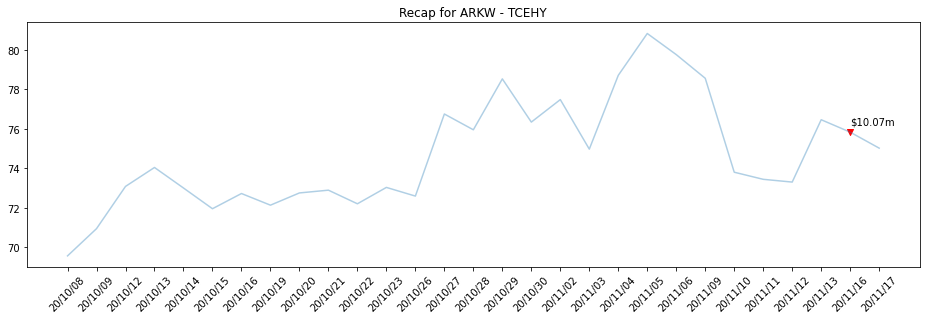

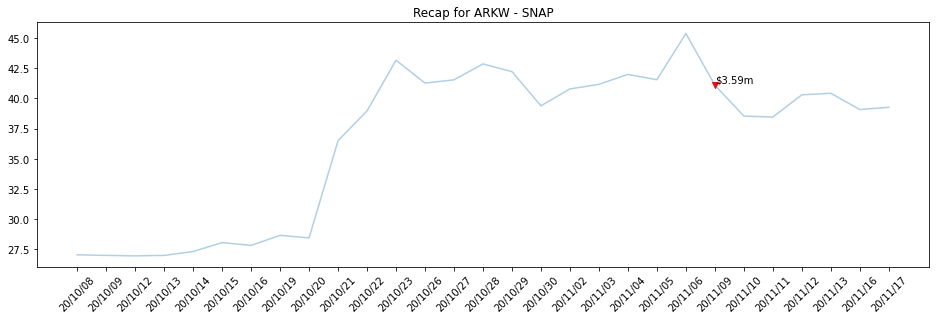

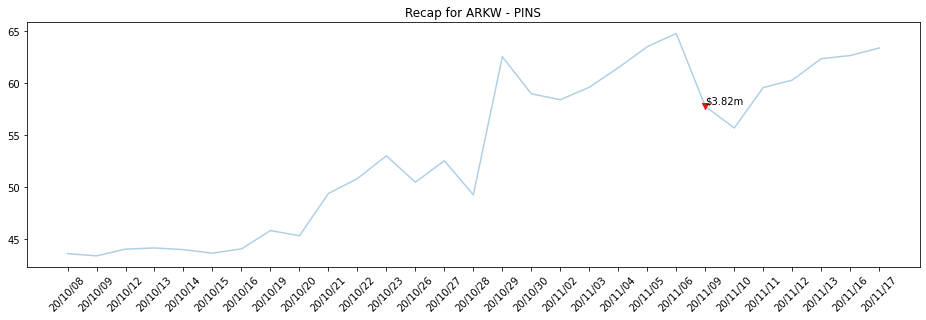

In [19]:
funds = list(set(data['FUND']))
for fund in funds:
    df_fund = data[data['FUND'] == fund]
    tickers = list(set(df_fund['Ticker']))
    for ticker in tickers:
        dt_stock = df_fund[df_fund['Ticker'] == ticker]
        df = refresh(ticker, period= "30d", interval = "1d")
        buy, sell, txt = genSignal(dt_stock, df)
    
        plt.figure(figsize=(16, 4.5))
        plt.plot(df["close"], label="close", alpha=0.35)
        plt.scatter(df.index, buy, color="green", label="buy", marker="^", alpha=1)
        plt.scatter(df.index, sell, color="red", label="sell", marker="v", alpha=1)
        plt.title(f'Recap for {fund} - {ticker}')
        plt.xticks(df.index, df["Date"], rotation = 45) 
    
        for i, t in enumerate(txt):
            plt.annotate(t, (df.index[i], df["close"][i] * 1.005))
    
        plt.show()